# CNMF demo pipeline: Intro
This demo provides a full pipeline for the analysis of a two-photon calcium imaging dataset using the CaImAn software package. It demonstrates how to use Caiman for the following analysis steps:

<a href="https://github.com/flatironinstitute/CaImAn/blob/main/demos/notebooks/images/full_cnmf_workflow.jpg?raw=true" target="_blank"><img src="https://github.com/flatironinstitute/CaImAn/blob/main/demos/notebooks/images/full_cnmf_workflow.jpg?raw=true"></a>

1) Apply the nonrigid motion correction (NoRMCorre) algorithm for motion correction.
2) Apply the constrained nonnegative matrix factorization (CNMF) source separation algorithm to extract initial estimates of neuronal spatial footprints and calcium traces.  
3) Apply quality control metrics to evaluate the initial estimates, and narrow down to the final set of estimates.

The CNMF algorithm is best for data with relatively low background noise, like most two-photon data and *some* one photon data (e.g., certain light sheet data).

<div class="alert alert-info">
    More detailed background information about CNMF can be found in the <a href="https://pubmed.ncbi.nlm.nih.gov/26774160/">original CNMF paper</a> and <a href="https://pubmed.ncbi.nlm.nih.gov/30652683/">the Caiman paper</a>.
</div>

## Imports and general setup
We first need to import the Python libraries we will use in the rest of the notebook and tweak some general settings. Don't worry about these details now, we will explain the important things when they come up. We import `caiman` as `cm`, so when you see `cm` in the rest of the notebook, it just means you are using something custom-written from the Caiman package.  

In [1]:
# Clone CaImAn from Github
!git clone https://github.com/flatironinstitute/CaImAn.git

# Install relevant packages
%cd /content/CaImAn
!pip install -r requirements.txt

# Install CaImAn package
!pip install -e .

# Install CaImAn manager for relevant datasets
!python caimanmanager.py install --inplace

Cloning into 'CaImAn'...
remote: Enumerating objects: 27820, done.
remote: Counting objects: 100% (2832/2832), done.
remote: Compressing objects: 100% (1151/1151), done.
remote: Total 27820 (delta 1816), reused 2518 (delta 1646), pack-reused 24988
Receiving objects: 100% (27820/27820), 556.93 MiB | 18.33 MiB/s, done.
Resolving deltas: 100% (18604/18604), done.
Updating files: 100% (211/211), done.
/content/CaImAn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.4/292.4 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/1

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
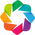

In [2]:
import bokeh.plotting as bpl
import cv2
import datetime
import glob
import holoviews as hv
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import psutil
from pathlib import Path

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf, params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.utils.visualization import view_quilt

bpl.output_notebook()
hv.notebook_extension('bokeh')

Continuing with our basic setup, we will set up a logger, and also set some environment variables in case that wasn't done already in your shell. If you want to learn more about Caiman's logger functionality, or tweak your logger (e.g., to log to file instead of your console), see [the relevant documentation](https://caiman.readthedocs.io/en/latest/Getting_Started.html#logging).

In [3]:
# set up logging
logging.basicConfig(format="{asctime} - {levelname} - [{filename} {funcName}() {lineno}] - pid {process} - {message}",
                    filename=None,
                    level=logging.WARNING, style="{") #logging level can be DEBUG, INFO, WARNING, ERROR, CRITICAL

# set env variables
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

In [4]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define source and destination paths
source_folder = '/content/drive/MyDrive/behavior&calcium-imaging-workshop/data/calcium-imaging-data'  # Update with your shared folder path
destination_folder = '/content/behavior&calcium-imaging-workshop/data/calcium-imaging-data'  # Content folder in Colab

# Copy files from source to destination folder
shutil.copytree(source_folder, destination_folder)

print("Files copied successfully!")

Mounted at /content/drive
Files copied successfully!


In [5]:
# Set the path to the data
movie_path = '/content/behavior&calcium-imaging-workshop/data/calcium-imaging-data/demoMovie.tif'
print(f"Original movie for demo is in {movie_path}")

Original movie for demo is in /content/behavior&calcium-imaging-workshop/data/calcium-imaging-data/demoMovie.tif


<div class="alert alert-info">
    <h2>Working with multiple files or sessions</h2>
     What if you have a recording that is broken up into multiple files, which is common for many acquisition systems? It is  easy to adapt the current demo for such cases. There are a couple of changes you would need to make. First, you would need to create a <i>list</i> of filepaths:<br>

    movie_path1 = download_demo('Sue_Split1.tif')
    movie_path2 = download_demo('Sue_Split2.tif')
    movie_paths = [movie_path1, movie_path2]

<br>Second, when creating the movie object, instead of using <em>cm.load()</em> you would use <em>cm.load_movie_chain()</em> which takes in a list as an argument:

    movie_orig = cm.load_movie_chain(movie_paths)
    

## Visualize raw data
Caiman has a built-in movie class for movie-viewing (documentation [here](https://caiman.readthedocs.io/en/latest/Handling_Movies.html)). Once you have loaded a movie using `cm.load()`, you can view it using `movie.play()`. The `play()` function has multiple parameters you can use to adjust the appearance of the movie:

    gain: brightness
    fr:  frame rate
    magnification: scale the size of the display  
    qmax, q_min: percentile for setting vmax, vmin -- below vmin is set to min, above vmax is set to max
    plot_text (Bool): show the frame number
    do_loop (Bool): whether to loop the video
    
**But we will not use this vizualizations because we are working in Colab environment.**

In [6]:
# press q to close
movie_orig = cm.load(movie_path)
# downsampling_ratio = 1  # subsample 5x
# movie_orig.resize(fz=downsampling_ratio).play(gain=1.3,
                                              #q_max=99.5,
                                              #fr=30,
                                              #plot_text=True,
                                              #magnification=2,
                                              #do_loop=False,
                                              #backend='opencv')

<div class="alert alert-info">
    <h2>Displaying large files</h2><br>
    
Loading a movie with <em>cm.load()</em> pulls the data into memory, which is not always feasible. When working with your own data, you might need to adapt the above code when working with extremely large files. Caiman provides tools to handle this use case. One, you can just load some of your data into a movie object using the `subindices` argument to the `load()` function. For example, if you just want to load the first 500 frames of a movie, you can send it <em>subindices=np.arange(0,500)</em>.<br>

If you don't want to truncate your movie, there is a <em>play_movie()</em> function that behaves just like <em>movie.play()</em>, but it doesn't load the movie into memory. Rather, it takes the filename as an argument and loads frames from disk as they are shown. If you want to use it, just import using <em>from caiman.base.movies import play_movie</em> and read the documentation. We don't use it for this demo because the demo movie is small, and we do some calculations on the loaded movie array.<br>

Another option for viewing very large movies is to use the <a href=https://github.com/fastplotlib/fastplotlib>fastplotlib library</a>, which leverages the GPU to provide interactive visualization within Jupyter notebooks (we discuss this more below).
</div>

Let's also create a couple of summary images of the movie, including a *maximum projection* (the maximum value of each pixel) and a *correlation image* (how correlated each pixel is with its neighbors). If a pixel comes from an active neural component it will tend to be highly correlated with its neighbors.

In [7]:
max_projection_orig = np.max(movie_orig, axis=0)
correlation_image_orig = cm.local_correlations(movie_orig, swap_dim=False)
correlation_image_orig[np.isnan(correlation_image_orig)] = 0 # get rid of NaNs, if they exist

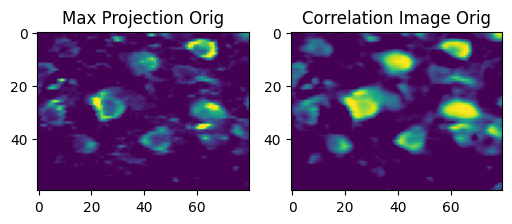

In [8]:
f, (ax_max, ax_corr) = plt.subplots(1,2,figsize=(6,3))
ax_max.imshow(max_projection_orig,
              cmap='viridis',
              vmin=np.percentile(np.ravel(max_projection_orig),50),
              vmax=np.percentile(np.ravel(max_projection_orig),99.5));
ax_max.set_title("Max Projection Orig", fontsize=12);

ax_corr.imshow(correlation_image_orig,
               cmap='viridis',
               vmin=np.percentile(np.ravel(correlation_image_orig),50),
               vmax=np.percentile(np.ravel(correlation_image_orig),99.5));
ax_corr.set_title('Correlation Image Orig', fontsize=12);

These images will not be particularly sharp yet, as there is still a good deal of motion in the movie.

> Note the above will generate static images. To view them interactively you can generate them in qt mode by running the cell magic `%matplotlib qt` at the beginning of this Jupyter notebook. If you are in colab or other cloud services, you can wrap figures using the [mpld3 package](https://github.com/mpld3/mpld3).

## Set initial parameters
In general in Caiman, estimators are first initialized with a set of parameters, and then they are fit against actual data in a separate step. In this section, we'll define a `parameters` object that will subsequently be used to initialize our different estimators.

The parameters are divided into different categories. We will not discuss them in detail in this section, but will go over them when needed (and note that in this notebook we will mostly focus on CNMF and later steps):

In [9]:
# general dataset-dependent parameters
fr = 50                     # imaging rate in frames per second
decay_time = 0.4            # length of a typical transient in seconds
dxy = (2., 2.)              # spatial resolution in x and y in (um per pixel)

# motion correction parameters
strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between patches (width of patch = strides+overlaps)
max_shifts = (6,6)          # maximum allowed rigid shifts (in pixels)
max_deviation_rigid = 3     # maximum shifts deviation allowed for patch with respect to rigid shifts
pw_rigid = True             # flag for performing non-rigid motion correction

# CNMF parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system (set p=2 if there is visible rise time in data)
gnb = 2                     # number of global background components (set to 1 or 2)
merge_thr = 0.85            # merging threshold, max correlation allowed
bas_nonneg = True           # enforce nonnegativity constraint on calcium traces (technically on baseline)
rf = 15                     # half-size of the patches in pixels (patch width is rf*2 + 1)
stride_cnmf = 10             # amount of overlap between the patches in pixels (overlap is stride_cnmf+1)
K = 4                       # number of components per patch
gSig = np.array([4, 4])     # expected half-width of neurons in pixels (Gaussian kernel standard deviation)
gSiz = 2*gSig + 1           # Gaussian kernel width and hight
method_init = 'greedy_roi'  # initialization method (if analyzing dendritic data see demo_dendritic.ipynb)
ssub = 1                    # spatial subsampling during initialization
tsub = 1                    # temporal subsampling during intialization

# parameters for component evaluation
min_SNR = 2.0               # signal to noise ratio for accepting a component
rval_thr = 0.85             # space correlation threshold for accepting a component
cnn_thr = 0.99              # threshold for CNN based classifier
cnn_lowest = 0.1            # neurons with cnn probability lower than this value are rejected

We place the above parameter values in a dictionary that is passed to the `CNMFParams` class (those parameters *not* explicitly defined will assume default values):

In [10]:
parameter_dict = {'fnames': movie_path,
                  'fr': fr,
                  'dxy': dxy,
                  'decay_time': decay_time,
                  'strides': strides,
                  'overlaps': overlaps,
                  'max_shifts': max_shifts,
                  'max_deviation_rigid': max_deviation_rigid,
                  'pw_rigid': pw_rigid,
                  'p': p,
                  'nb': gnb,
                  'rf': rf,
                  'K': K,
                  'gSig': gSig,
                  'gSiz': gSiz,
                  'stride': stride_cnmf,
                  'method_init': method_init,
                  'rolling_sum': True,
                  'only_init': True,
                  'ssub': ssub,
                  'tsub': tsub,
                  'merge_thr': merge_thr,
                  'bas_nonneg': bas_nonneg,
                  'min_SNR': min_SNR,
                  'rval_thr': rval_thr,
                  'use_cnn': True,
                  'min_cnn_thr': cnn_thr,
                  'cnn_lowest': cnn_lowest}

parameters = params.CNMFParams(params_dict=parameter_dict) # CNMFParams is the parameters class

This parameters object (`parameters`) is basically a collection of dictionaries, each containing a different parameter category. These different dictionaries can be accessed using dot notation.  Some parameters are related to the dataset in general (`parameters.data`), while most are related to specific aspects of the workflow such as motion correction (`parameters.motion`) or quality evaluation (`parameters.quality`).

For instance, if you want to inspect the dataset-dependent parameters:

In [11]:
parameters.data

{'fnames': ['/content/behavior&calcium-imaging-workshop/data/calcium-imaging-data/demoMovie.tif'],
 'dims': (60, 80),
 'fr': 50,
 'decay_time': 0.4,
 'dxy': (2.0, 2.0),
 'var_name_hdf5': 'mov',
 'caiman_version': '1.10.5',
 'last_commit': 'GITW-83ce6ceea568d2bb6ee5f0af64e65993397e5dc3',
 'mmap_F': None,
 'mmap_C': None}

To access a particular parameter in this parameter field, you just need to get the value from the dictionary using the appropriate key. For instance, to get the frame rate:

In [12]:
parameters.data['fr']

50

## Set up multicore processing
Caiman is optimized for parallel computing, and distributes computations to multiple CPU cores for motion correction and CNMF. Setting up the multicore processing is done with the `setup_cluster()` function below.

First, let's see how many CPUs we have available, and set the number of processors we want to use. If you set `num_processors_to_use` to `None`, then `setup_cluster()` will set it to the default of *one less* than the total number available:

In [13]:
print(f"You have {psutil.cpu_count()} CPUs available in your current environment")
num_processors_to_use = None

You have 2 CPUs available in your current environment


Initialize a cluster of processors. If one has already been set up (the `cluster` variable is already in your namespace), then that cluster will be closed and a new one created.

In [14]:
if 'cluster' in locals():  # 'locals' contains list of current local variables
    print('Closing previous cluster')
    cm.stop_server(dview=cluster)
print("Setting up new cluster")
_, cluster, n_processes = cm.cluster.setup_cluster(backend='multiprocessing',
                                                   n_processes=num_processors_to_use,
                                                   ignore_preexisting=False)
print(f"Successfully initilialized multicore processing with a pool of {n_processes} CPU cores")

Setting up new cluster
Successfully initilialized multicore processing with a pool of 1 CPU cores


The `cluster` variable is the pool of processors (CPUs) that will be used in many of Caiman's subsequent processing steps. In these later steps, if you set the parameter `dview` to `cluster`, then parallel processing will be used. If instead you set `dview` to `None` then no parallel processing will be used. This latter option can be helpful when debugging, as the logger doesn't typically work for multi-CPU operations.

For more details, please see [our documentation on cluster setup](https://caiman.readthedocs.io/en/latest/Getting_Started.html#cluster-setup-and-shutdown).

<div class="alert alert-info" markdown="1">
    <h2 style="margin-top: 0;">Optimizing performance</h2>
<br>    
If you hit memory issues later, there are a few things you can do. First, you may want to lower the number of processors you are using. Each processor uses more RAM, and on a workstation with many processors, you can sometimes get better performance by reducing <em>num_processors_to_use</em>.The best way to determine the optimal number is by trial and error. When you set <em>num_processors_to_use</em> variable to <em>None</em>, it defaults to <i>one</i> less than the total number of CPU cores available (the reason we don't automatically set it to the total number of cores is because in practice this typically leads to worse performance).<br>

Second, if your system has less than 32GB of RAM, and things are running slowly or you are running out of memory, then get more RAM. While you can sometimes get away with less, we recommend a *bare minimum* level of 16GB of RAM, but more is better. 32GB RAM is acceptable, 64GB or more is best. Obviously, this will depend on the size of your data sets.<br>

Third, if none of your memory optimizations work, you may just have too much data for offline CNMF. For this case, we also provide an online version of CNMF (OnACID), which uses a small number of frames to initialize the spatial and temporal components, and iteratively updates them with new data. This uses much less memory than the offline approach. The demo notebook for OnACID is found in <a href="./demo_OnACID_mesoscope.ipynb">demo_OnACID_mesoscope.ipynb</a>. See the <a href="https://pubmed.ncbi.nlm.nih.gov/30652683/">Caiman paper</a> for more discussion.
</div>

## Motion Correction
The first substantive step in our analysis pipeline is to remove motion artifacts from the original movie:

<a href="https://github.com/flatironinstitute/CaImAn/blob/main/demos/notebooks/images/normcorre_workflow.jpg?raw=true" target="_blank"><img src="https://github.com/flatironinstitute/CaImAn/blob/main/demos/notebooks/images/normcorre_workflow.jpg?raw=true"></a>

It is *very* important to get rid of motion artifacts, as the subsequent CNMF source separation algorithm assumes that each pixel represents the same region of space

First, we initialize the motion correction estimator using the parameters that we set above:   

In [15]:
mot_correct = MotionCorrect(movie_path, dview=cluster, **parameters.motion)

This notebook focuses on CNMF, not motion correction, but let's consider a couple of the motion correction parameters:

- `pw_rigid=True` tells us that we are going to perform piecewise rigid motion correction using the nonrigid motion correction (NoRMCorre) algorithm (this is because the data seems to exhibit some non-uniform motion). If your data exhibits uniform motion across the field of view, set this to `False` for efficiency.
- NoRMCorre will split the movie into patches that repeat every 48 pixels (`strides`), and have 24 pixels of overlap (`overlaps`): the total patch width is 72 (the sum of stride and overlap).

<div class="alert alert-info" markdown="1">
    <h2 style="margin-top: 0;">For more on motion correction</h2>  
For a detailed exploration of Caiman's motion correction pipeline, see the <a href="./demo_motion_correction.ipynb">demo_motion_correction.ipynb</a> demo.
</div>

The next step is to run the motion correction algorithm using the `motion_correct()` method. You may see some warnings about negative movie averages: you can ignore them.

In [16]:
%%time
#%% Run piecewise-rigid motion correction using NoRMCorre
mot_correct.motion_correct(save_movie=True);

CPU times: user 369 ms, sys: 38.4 ms, total: 407 ms
Wall time: 18.1 s


Inspect the results: compare the original movie with the motion corrected movie. We are turning the gain up here to highlight motion.

In [17]:
movie_orig = cm.load(movie_path) # in case it was not loaded earlier
movie_corrected = cm.load(mot_correct.mmap_file) # load motion corrected movie

100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


Let's look at the max projection and correlation image of the motion corrected movies. In movies that originally contained a lot of movement, the summary images will look more "crisp" than in the originals because they are no longer blurred by movement:

In [18]:
max_projection = np.max(movie_corrected, axis=0)
correlation_image = cm.local_correlations(movie_corrected, swap_dim=False)
correlation_image[np.isnan(correlation_image)] = 0 # get rid of NaNs, if they exist

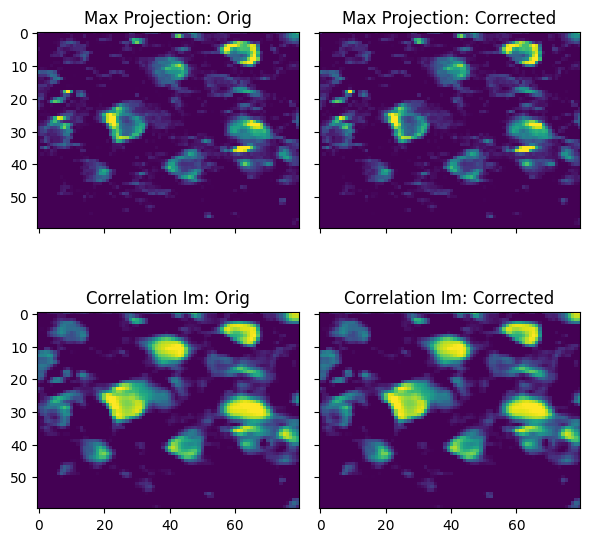

In [19]:
f, ((ax_max_orig, ax_max), (ax_corr_orig, ax_corr)) = plt.subplots(2,2,figsize=(6,6), sharex=True, sharey=True)
# plot max projection
ax_max_orig.imshow(max_projection_orig,
                   cmap='viridis',
                   vmin=np.percentile(np.ravel(max_projection_orig),50),
                   vmax=np.percentile(np.ravel(max_projection_orig),99.5));
ax_max_orig.set_title("Max Projection: Orig", fontsize=12);
ax_max.imshow(max_projection,
              cmap='viridis',
              vmin=np.percentile(np.ravel(max_projection),50),
              vmax=np.percentile(np.ravel(max_projection),99.5));
ax_max.set_title("Max Projection: Corrected", fontsize=12);

# plot correlation image
ax_corr_orig.imshow(correlation_image_orig,
                    cmap='viridis',
                   vmin=np.percentile(np.ravel(correlation_image_orig),50),
                   vmax=np.percentile(np.ravel(correlation_image_orig),99.5));
ax_corr_orig.set_title('Correlation Im: Orig', fontsize=12);
ax_corr.imshow(correlation_image,
               cmap='viridis',
               vmin=np.percentile(np.ravel(correlation_image),50),
               vmax=np.percentile(np.ravel(correlation_image),99.5));
ax_corr.set_title('Correlation Im: Corrected', fontsize=12);

plt.tight_layout()

## Creating and accessing memory mapped files
The next step is to handle the motion corrected file in memory using a *memory mapped* file. This lets us treat the data *as if* it were in memory while leaving it on disk (for more details about memory mapping, see [our documentation](https://caiman.readthedocs.io/en/latest/Getting_Started.html#memory-mapping)).

In [20]:
border_to_0 = 0 if mot_correct.border_nan == 'copy' else mot_correct.border_to_0 # trim border against NaNs
mc_memmapped_fname = cm.save_memmap(mot_correct.mmap_file,
                                        base_name='memmap_',
                                        order='C',
                                        border_to_0=border_to_0,  # exclude borders, if that was done
                                        dview=cluster)

Yr, dims, num_frames = cm.load_memmap(mc_memmapped_fname)
images = np.reshape(Yr.T, [num_frames] + list(dims), order='F') #reshape frames in standard 3d format (T x X x Y)

Restart the cluster to clean up memory in preparation for CNMF run.

In [21]:
cm.stop_server(dview=cluster)
_, cluster, n_processes = cm.cluster.setup_cluster(backend='multiprocessing',
                                                   n_processes=num_processors_to_use,
                                                   single_thread=False)

# Run CNMF on patches in parallel

Everything is now set up for running CNMF. This algorithm simultaneously extracts the *spatial footprint* and corresponding *calcium trace* for each component.


<a href="https://github.com/flatironinstitute/CaImAn/blob/main/demos/notebooks/images/cnmf_workflow.jpg?raw=true" target="_blank"><img src="https://github.com/flatironinstitute/CaImAn/blob/main/demos/notebooks/images/cnmf_workflow.jpg?raw=true"></a>

It also performs *deconvolution*, providing an estimate of the spike count that generated the calcium signal in the movie.

The algorithm is parallelized as illustrated here:

<img src="https://github.com/flatironinstitute/CaImAn/blob/main/demos/notebooks/images/cnmf_patches.jpg?raw=true" alt="cnmf patch flow" width="500"/>

1) The movie field of view is split into overlapping patches.
2) These patches are processed in parallel by the CNMF algorithm. The degree of parallelization depends on your available computing power: if you have just one CPU then the patches will be processed sequentially.
3) The results from all the patches are merged, with special focus on components in overlapping regions -- overlapping components are merged if their activity is highly correlated.
4) Results are refined with additional iterations of CNMF (the `refit()` algorithm is run).

As discussed above, Caiman's main algorithms are run in two steps: first the estimators are *initialized* with a set of parameters, and then they are *fit* against actual data. Let's initialize our CNMF estimator object:

In [22]:
cnmf_model = cnmf.CNMF(n_processes,
                       params=parameters,
                       dview=cluster)

Once initialized, we we could immediately run `cnmf_model.fit(images)` if we knew the parameters were good -- the parameters in your CNMF estimator object are accessible in `cnmf_model.params`. Before running the algorithm, let's go over the key parameters for CNMF. The default values typically work fine for most parameters: there are just a few that you will need to alter based on your data:

### Key parameters for CNMF

`rf (int)`: *patch half-width*

> `rf` ('receptive field') is the half width of patches that in pixels (the actual patch width is `2*rf + 1`). See previous image for a representation of how the field of view is split up into patches for parallel procesing. `rf` should be *at least* 3-4 times larger than the observed neuron diameter. The larger the patch size, the less parallelization will be used by Caiman. If `rf` is set to `None`, then CNMF will be run on the entire field of view.

`stride (int)`: *patch overlap*

> `stride` is the overlap between patches in pixels (the actual overlap is `stride + 1`). This should be at least the diameter of a neuron. The larger the overlap, the greater the computational load, but the results will be more accurate when stitching together results from different patches.

`K (int)`: *components per patch*

> `K` is the expected number of components per patch. You should adapt this to the density of components in your data, and the current `rf` parameter. We suggest you pick `K` based on the more dense patches in your movie so you don't miss neurons (we want to avoid false negatives).

`gSig (int, int)`: *half-width of neurons*

> `gSig` is roughly the half-width of neurons in your movie in pixels (height, width): it is the sigma parameter of a Gaussian filter run on all the images during initialization. If the filter matches the neurons, you will get a much better estimate. `gSig` goes with `gSiz`, which is the kernel size (height and width in pixels) used for the filter. See the `GaussianBlur()` OpenCV function for more details on the sigma and size parameters.
    
   
`merge_thr (float)`: *merge threshold*

> If two spatially overlapping components are correlated above `merge_thr`, they will be merged into one component. The correlation coefficient is calculated using their calcium traces. If Caiman identifies a "component" that clearly contains two overlapping components, then increase `merge_thr`.

You typically will set `rf` and `stride` infrequently, so `K`, `gSig`, and `merge_thr` are the main parameters you will tweak when analyzing a given session. Note these are not the *only* important parameters. They just tend to be the *most* important: the others tend to depend on your calcium indicator or other factors that don't vary within an experimental session.

### Selecting spatial parameters
To select the spatial parameters (`gSig`, `rf`, `stride`, `K`), you need to look at your movie, or a summary image for your movie, and pick values close to those suggested by the guidelines above.

Patch width: 31 , Stride: 20, Overlap: 11


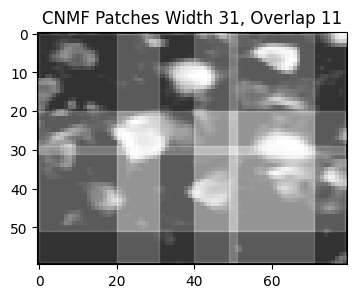

In [23]:
# calculate stride and overlap from parameters
cnmf_patch_width = cnmf_model.params.patch['rf']*2 + 1
cnmf_patch_overlap = cnmf_model.params.patch['stride'] + 1
cnmf_patch_stride = cnmf_patch_width - cnmf_patch_overlap
print(f'Patch width: {cnmf_patch_width} , Stride: {cnmf_patch_stride}, Overlap: {cnmf_patch_overlap}');

# plot the patches
patch_ax = view_quilt(correlation_image,
                      cnmf_patch_stride,
                      cnmf_patch_overlap,
                      vmin=np.percentile(np.ravel(correlation_image),50),
                      vmax=np.percentile(np.ravel(correlation_image),99.5),
                      figsize=(4,4));
patch_ax.set_title(f'CNMF Patches Width {cnmf_patch_width}, Overlap {cnmf_patch_overlap}');

Let's evaluate our spatial parameters using the quilt plot

- Is the patch width at least three times the width of a neuron? Yes
- Do individual neurons fit in the overlap region (`stride`)? Yes.
- When in interactive mode, you can zoom and inspect the average width of each neuron in pixels. Is `gSig` about half that? Yes. Each neuron is about 6-8 pixels wide, and `gSig` is 4.
- For `K`: how many neurons are in each patch? Remember you want an upper bound, not an average. The current value of 4 seems good.

Keep in mind that there is typically no *perfect* set of parameter values: ultimately the only way to know if a set of parameters is good is to fit the model and see how well it performs. Sometimes you just have to iteratively search a bit in parameter space.

<div class="alert alert-info" markdown="1">
    <h2 style="margin-top: 0;">How to change parameters</h2>  
    
If the parameters were <em>not</em> good, then you could change them using the `change_params()` method, which takes in a dictionary of new parameter values. For instance, if we wanted to change gSig to 5:<br>

    new_parameters = {'gSig': 5}
    cnmf_model.params.change_params(params_dict=new_parameters)
      
<br>It is not always efficient to cobble together iterative parameter search from scratch, especially if you end up needing to do a grid search in a large parameter space. <a href=https://github.com/nel-lab/mesmerize-core>Mesmerize</a> is a great package built to make parameter exploration in Caiman faster and more convenient: it keeps track of all your different results, and includes powerful GPU-based tools (based on the <a href="https://github.com/fastplotlib/fastplotlib">fastplotlib library</a>) for visualization of results in Jupyter notebooks.
</div>

### Run CNMF
Now that we are happy with our parameters, let's run the cnmf algorithm using the `fit()` method.

In [24]:
%%time
cnmf_fit = cnmf_model.fit(images)

CPU times: user 765 ms, sys: 551 ms, total: 1.32 s
Wall time: 8.89 s


Briefly inspect the results by plotting contours of identified components using `plot_contours_nb()`.

You can interactively explore this plot in your notebook with the help of the buttons on the right-hand-side of the plot (it was made using the [Bokeh](https://bokeh.org/) library). They let you zoom, pan, reset, or save the image.

In [25]:
cnmf_fit.estimates.plot_contours_nb(img=correlation_image)

Note this is just an initial result, which will contain many false positives, which is to be expected. The main concern to watch for here is whether you have lots of false *negatives* (**has the algorithm missed neurons?**). False negatives are hard to fix later, so if you have an unacceptable number, be sure to go back and re-run CNMF with new parameters.

### Re-run (seeded) CNMF  on the full field of view
It is usually helpful to refine the initial estimates by re-running the CNMF algorithm seeded just on the spatial estimates from the previous step using the `refit()` method.

In [26]:
%%time
cnmf_refit = cnmf_fit.refit(images, dview=cluster)

CPU times: user 1.04 s, sys: 428 ms, total: 1.47 s
Wall time: 15.9 s


The spatial contours of the new estimates should now look cleaner and more canonically neuronal in shape:

In [27]:
cnmf_refit.estimates.plot_contours_nb(img=correlation_image);

While the estimates look better, there is still garbage that was collected: there are still false positives. The next **component evaluation** stage of the pipeline will evaluate the initial set of estimates, and remove the bad ones. But first, let's disuss the estimates object.

# The estimates class
The main point of the CNMF algorithm is to perform source separation to extract the location of neurons and calcium activity traces from your raw data. This information, and many useful methods for visualization and analysis, are contained in Caiman's `Estimates` class. In the above code, an `estimates` object was generated when you ran the CNMF algorithm (you can find it in `cnmf_refit.estimates`).

The rest of this notebook, from component evaluation to calculation of DFoF, is effectively an exploration of the properties and methods of the `Estimates` class. The most important estimates generated, which are properties of the `cnmf_refit.estimates`, are given in the following table:

| Variable | Meaning | Shape |
|:-------- |:------------- |:--------------------- |
| **C** | Denoised calcium traces |  num components x num_frames |
| **F_dff** | $\Delta F/F$ |  num_components x num_frames |
| **S** | Spike count estimate for each component from deconvolution, if used |  num_components x num_frames |
| **YrA** | Residual for each trace |  num_components x num_frames |
| **A** | Spatial components/footprints |  num pixels x num components |

To recover raw calcium traces, you can add together the denoised calcium traces and their residuals (`C + YrA`). Note that the `F_dff` calculation is not done automatically, so when you run `fit()` the `F_dff` field will initially be `None`. We will show how to do populate that field below.

In [28]:
# see shape of A and C
cnmf_refit.estimates.A.shape, cnmf_refit.estimates.C.shape

((4800, 18), (18, 2000))

# Component Evaluation
As already mentioned, the initial estimates produced by CNMF contains many spurious components. Our next step is to do some some quality control, cutting out the bad estimates to arrive at our final set of estimates:


We will evaluate each component by applying the `evaluate_components()` method. The criteria Caiman uses to evaluate components are:  

- **Signal to noise ratio (SNR)**: a baseline noise estimate is extraced for each raw calcium trace, and SNR during calcium transients is calculated relative to this baseline. These values are stored in `estimates.SNR_comp`. Those components with high SNR are higher quality, and less likely to be false positives.
- **Spatial correlation**: the extracted spatial footprints in `estimates.A` should be highly correlated with activity in the actual movie, at least on those frames when that component is active. These correlation coefficients are stored in `estimates.r_values`.
- **CNN confidence**: Each spatial component in `estimates.A` is passed through a CNN-based classifier, trained on consensus data sets, that produces a confidence value between 0 and 1 that the shape is a real neuron. These are stored in `estimates.cnn_preds`.

The first two criteria are illustrated schematically here (see also Figure 2 of <a href="https://elifesciences.org/articles/38173">the Caiman paper</a>):

<img src="https://github.com/flatironinstitute/CaImAn/blob/main/demos/notebooks/images/component_evaluation.jpg?raw=true" alt="component evaluation" width="1000"/>


The `evaluate_components()` method uses the above criteria to sort components into accepted and rejected components. For each criterion, there is a threshold value in `quality` field of the parameters object -- the thresholds are `min_SNR`, `rval_thr`, and `min_cnn_thr`, respectively. If a unit is below *all* of those threshold values, it will be rejected.

In [29]:
print("Thresholds to be used for evaluate_components()")
print(f"min_SNR = {cnmf_refit.params.quality['min_SNR']}")
print(f"rval_thr = {cnmf_refit.params.quality['rval_thr']}")
print(f"min_cnn_thr = {cnmf_refit.params.quality['min_cnn_thr']}")

Thresholds to be used for evaluate_components()
min_SNR = 2.0
rval_thr = 0.85
min_cnn_thr = 0.99


In [30]:
cnmf_refit.params.quality['use_cnn'] = False

In [31]:
cnmf_refit.params.quality['use_cnn']

False

Run `estimates.evaluate_components()`. This can take a few minutes if you have a very large number of components:

In [32]:
cnmf_refit.estimates.evaluate_components(images, cnmf_refit.params, dview=cluster);

This method filled in two arrays in the `estimates` class: `idx_components` (accepted) and `idx_components_bad` (rejected).

In [33]:
print(f"Num accepted/rejected: {len(cnmf_refit.estimates.idx_components)}, {len(cnmf_refit.estimates.idx_components_bad)}")

Num accepted/rejected: 18, 0


<div class="alert alert-info" markdown="1">
    <h2 style="margin-top: 0;">More on component evaluation</h2>  
In practice, SNR is the most important evaluation factor. The spatial correlation factors are less important. In particular, the CNN for spatial evaluation may be inaccurate if your neural components are not "canonically" shaped somata.


<br>When running <em>evaluate_components()</em> the three evaluation thresholds are appied <em>inclusively</em>: if a component is above <em>any</em> of the thresholds, it will pass muster. This was found in practice to be reasonable (e.g., a low SNR component that is very strongly neuronally shaped tends to not be an accident: it is just a very low SNR neuron). However, there is a second set of <b>absolute</b> threshold parameters  set for each criterion. If a component is <em>below</em> this absolute threshold for any of the evaluation parameters, it will be discarded: these are the <em>SNR_lowest</em>, <em>rval_lowest</em>, and <em>cnn_lowest</em>, respectively.
</div>

## Visualizing results
We've sorted our components into accepted/rejected, so it's time to start looking at the results! Caiman provides many built-in `estimates` methods for visualizaing results.

### All contours
We have already used `plot_contours_nb()`, but if we provide it the `idx` keyword it will split the view into accepted and rejected components.

In [34]:
cnmf_refit.estimates.plot_contours_nb(img=correlation_image,
                                      idx=cnmf_refit.estimates.idx_components);

### View individual spatial/temporal components
One of the most useful visualization tools is `nb_view_components()`, which lets you scroll through individiual spatial and temporal components. This tool also displays the values of the three evaluation criteria for each component, which can be useful if you feel you need to change your evaluation criteria and re-run `evaluate_components()`. Perhaps you have too many false negatives and want to lower your SNR threshold.

In [35]:
# view accepted components
cnmf_refit.estimates.nb_view_components(img=correlation_image,
                                        idx=cnmf_refit.estimates.idx_components,
                                        cmap='gray');

In [37]:
load_results = False
if load_results:
    save_path =  r'demo_pipeline_results.hdf5'  # or add full/path/to/file.hdf5
    cnmf_refit = cnmf.load_CNMF(save_path,
                                n_processes=num_processors_to_use,
                                dview=cluster)
    correlation_image = cnmf_refit.estimates.Cn
    print(f"Successfully loaded data.")

# A few final things
We have extracted the calcium traces `C`, spatial footprints `A`, and estimated spike counts `S`, which is the main goal with CNMF. But there are a few important things remaining.

## Select only accepted components (optional)
If you want to discard rejected components (`estimates.idx_components_bad`) from the `estimates` field, you can run  `select_components()`. This can be useful if you are sure you only want to focus on the accepted components for downstream analysis (e.g., to share final results with colleagues, for instance).

<div class="alert alert-warning" markdown="1">
    <h4 style="margin-top: 0;">Warning: select_components() is a destructive operation</h4>  
If you run this command, the rejected components will be removed from your <em>estimates</em> field. If you think you might want them later, you can set the <em>save_discarded_components</em> parameter to <em>True</em>. This will let you retrieve them later with the <em>restore_discarded_components()</em> method.
</div>

In [38]:
cnmf_refit.estimates.select_components(use_object=True);

*** Variable cnn_preds has not the same number of components as A ***


The `use_object` parameter specifies that we want to select the accepted components in `estimates.idx_components` (and remove the components in `idx_components_bad`).

## Save results to csv
When we showed how to save/load the cnmf model above, that was for working with the entire estimator object (for instance if you want to save your work and start again later). Often users just want to save certain results such as the calcium traces in `C` to csv and do downstream analysis later. In Python it is easiest to do this using the Pandas package.

The following shows how to save your calcium traces to a file called `C_traces.csv`, to the `caiman_data` folder. You can adapt this code to save other data fields such as dff. We will also save the frame times as a convenient reference.

In [39]:
frame_rate = cnmf_refit.params.data['fr']
frame_pd = 1/frame_rate
frame_times = np.linspace(0, num_frames*frame_pd, num_frames);

In [40]:
data_to_save = np.vstack((frame_times, cnmf_refit.estimates.C)).T  # Transpose so time series are in columns
save_df = pd.DataFrame(data_to_save)
save_df.rename(columns={0:'time'}, inplace=True)
# check out the dataframe
save_df.head()

,time,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.00000,0.0,0.0,809.775732,2339.862914,0.0,0.0,0.0,0.0,0.0,46.352518,0.0,0.0,0.0,0.0,0.0,3145.399203,0.0,148.824885
1,0.02001,0.0,0.0,746.747519,2176.993836,0.0,0.0,0.0,0.0,0.0,41.789727,0.0,0.0,0.0,0.0,0.0,2879.828039,0.0,135.705844
2,0.04002,0.0,0.0,688.625043,2138.753702,0.0,0.0,0.0,0.0,0.0,37.676081,0.0,0.0,0.0,0.0,0.0,2636.679487,0.0,123.743262
3,0.06003,0.0,0.0,635.026465,1989.882980,0.0,0.0,0.0,0.0,0.0,33.967369,0.0,0.0,0.0,0.0,0.0,2853.775330,0.0,112.835183
4,0.08004,0.0,0.0,585.599720,1851.374667,0.0,0.0,0.0,0.0,0.0,30.623732,0.0,0.0,0.0,0.0,0.0,2612.826586,0.0,102.888669


Set up file path and save using the Pandas `to_csv()` method:

In [44]:
# c_save_path = '/content' + f'/C_traces-{movie_path}.csv'
save_df.to_csv('/content/traces.csv', index=False)

# What next?
The goal of Caiman is to help you extract high-quality signals from your data, and we have achieved that goal with the above steps. The next step, of doing actual *analysis* of these results, is where the most interesting neuroscience happens: what are the statistical features of these signals? How do they relate to other environmental, molecular, behavioral, and neuronal features that you are studying? What kinds of visualization and analysis tools can you build around this infrastructure?

# Clean up open resources
We have a few resources we have left open we should take care of.

## Shut down cluster
To free up processing resources, let's shut down the cluster in case it is still open.

In [45]:
cm.stop_server(dview=cluster)

## Shut down logger, optionally remove log files
If you set up your logger to log to files, and you don't want to preserve them, you can delete them with the following. If you have custom log filenames, you may have to change the `log_files` pattern for the following to work.

In [46]:
# Shut down logger (otherwise will not be able to delete it)
logging.shutdown()

In [47]:
delete_logs = True
logging_dir = cm.paths.get_tempdir()
if delete_logs:
    log_files = glob.glob(logging_dir + '\\demo_pipeline' + '*' + '.log')
    for log_file in log_files:
        print(f"Deleting {log_file}")
        os.remove(log_file)
else:
    print(f"If you want to inspect your logs they are in {logging_dir}")